# Synthetic Data Generation Using Generalized Additive Models

In this notebook, we train GAM models to predict discharge values for HJ Andrews River Sites across time, which can then be used to infer dry (0) or wet (1) status for a given site on a given date.

We use the following techniques:
- **PyGAM** with seasonal spline smoothing to capture temporal patterns
- **Site-specific scaling** to normalize predictions across different stream characteristics
- **Forward-filling** for robust handling of missing data

At the bottom of the notebook, we provide a function for practitioners to plot discharge predictions with our trained models for a site.

## Imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

## Data Preprocessing

In [32]:
# Load pivoted observation data
obs_pivot = pd.read_csv("/Users/alexhuang/Downloads/obs_pivot.csv")

# Select the top 10 sites with the most non-missing discharge observations
top_sites = (
    obs_pivot[~obs_pivot["Discharge_CMS"].isna()]
    ["NHDPlusID"]
    .value_counts()
    .index[:10]
)

# Keep only selected sites and valid discharge values
training_df = obs_pivot[
    (obs_pivot["NHDPlusID"].isin(top_sites)) &
    (~obs_pivot["Discharge_CMS"].isna())
].copy()

# Log-transform discharge (used for modeling; exponentiate for interpretation)
training_df["log_discharge"] = np.log(training_df["Discharge_CMS"])

# Convert date column and compute day-of-year
training_df["Date"] = pd.to_datetime(training_df["Date"])
training_df["doy"] = training_df["Date"].dt.dayofyear

# Preview processed training data
training_df.head()

/Users/alexhuang/saas-river-forecasting/saas-river-forecasting/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Date,NHDPlusID,Discharge_CMS,Flow_Status,HoboWetDry0.05,MaxDepth_Censor,MaxDepth_Threshold,MaxDepth_cm,log_discharge,doy
0,1980-01-01,55000900029021,0.007362,NaN,NaN,NaN,NaN,NaN,-4.911372,1
1,1980-01-01,55000900029608,0.350421,NaN,NaN,NaN,NaN,NaN,-1.048620,1
2,1980-01-01,55000900061097,3.369699,NaN,NaN,NaN,NaN,NaN,1.214823,1
3,1980-01-01,55000900095919,0.003794,NaN,NaN,NaN,NaN,NaN,-5.574214,1
4,1980-01-01,55000900130309,0.045505,NaN,NaN,NaN,NaN,NaN,-3.089929,1


## Model Training

In [27]:
def fit_gam(df, target_col="Discharge_CMS", n_splines=50):
    """
    Fit a global GAM using day-of-year as the predictor.
    Only finite target values are used in model fitting.
    """

    # Extract predictor (day of year) and target
    X = df["doy"].values.reshape(-1, 1)
    y = df[target_col].values

    # Mask invalid target values
    valid_mask = np.isfinite(y)

    # Fit GAM model
    gam = LinearGAM(
        s(0, n_splines=n_splines)
    ).fit(X[valid_mask], y[valid_mask])

    return gam


# Fit global GAM model
global_gam = fit_gam(training_df)

In [28]:
def predict_site_gam(df_site, target_col="Discharge_CMS"):
    """
    Predict discharge for a single site using a global seasonal GAM + site-specific scaling.

    Parameters:
        df_site : pd.DataFrame
            Must have columns ['Date', 'Discharge_CMS'] for a single site.
        n_splines : int
            Number of splines for the GAM (higher -> more flexible seasonal peaks)

    Returns:
        pd.DataFrame with ['Date','Discharge_CMS','seasonal','pred_flow']
    """

    df = df_site.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['doy'] = df['Date'].dt.dayofyear

    mask = df[target_col].notna() & np.isfinite(df[target_col])
    if mask.sum() == 0:
        df['seasonal'] = np.nan
        df['pred_flow'] = np.nan
        return df

    df['seasonal'] = global_gam.predict(df['doy'].values.reshape(-1,1))

    A = np.vstack([np.ones(mask.sum()), df.loc[mask, 'seasonal']]).T
    y_obs = df.loc[mask, target_col].values
    a, b = np.linalg.lstsq(A, y_obs, rcond=None)[0]

    df['pred_flow'] = a + b * df['seasonal']
    df['pred_flow'] = np.maximum(df['pred_flow'], 0)

    return df

## Applying GAM to All Sites

In [29]:
# Load and preprocess data
discharge_df = obs_pivot[~obs_pivot['Discharge_CMS'].isna()]
discharge_df['Date'] = pd.to_datetime(discharge_df['Date'])
discharge_df['NHDPlusID'] = discharge_df['NHDPlusID'].astype(str)

# Helper function to create a complete date series for a site
def make_df(site):
    start_date = discharge_df['Date'].min()
    end_date   = discharge_df['Date'].max()
    df_site = discharge_df[discharge_df['NHDPlusID']==site][['Date','Discharge_CMS']]
    full_dates = pd.DataFrame({'Date': pd.date_range(start=start_date, end=end_date, freq='D')})
    df_full = full_dates.merge(df_site, on='Date', how='left')

    return df_full

In [30]:
# Generate predictions for all sites
all_preds = []

for site in discharge_df['NHDPlusID'].value_counts().index:
    df_site = make_df(site)
    
    # Apply GAM prediction function (assumes predict_site_gam is defined)
    df_site = predict_site_gam(df_site)
    
    df_site['NHDPlusID'] = site
    all_preds.append(df_site)

# Combine predictions into a single DataFrame
predictions_df_gam = pd.concat(all_preds, ignore_index=True)

# Fill missing discharge values with predicted flow
predictions_df_gam['combined_prediction'] = predictions_df_gam['Discharge_CMS'].fillna(
    predictions_df_gam['pred_flow']
)

# Preview results
display(predictions_df_gam.head())

,Date,Discharge_CMS,doy,seasonal,pred_flow,NHDPlusID,combined_prediction
0,1980-01-01,3.369699,1,0.728643,6.277991,55000900061097,3.369699
1,1980-01-02,3.171482,2,0.676954,5.831628,55000900061097,3.171482
2,1980-01-03,3.539600,3,0.649490,5.594465,55000900061097,3.539600
3,1980-01-04,3.596234,4,0.641973,5.529554,55000900061097,3.596234
4,1980-01-05,11.439987,5,0.650124,5.599944,55000900061097,11.439987


## Plotting Predictions

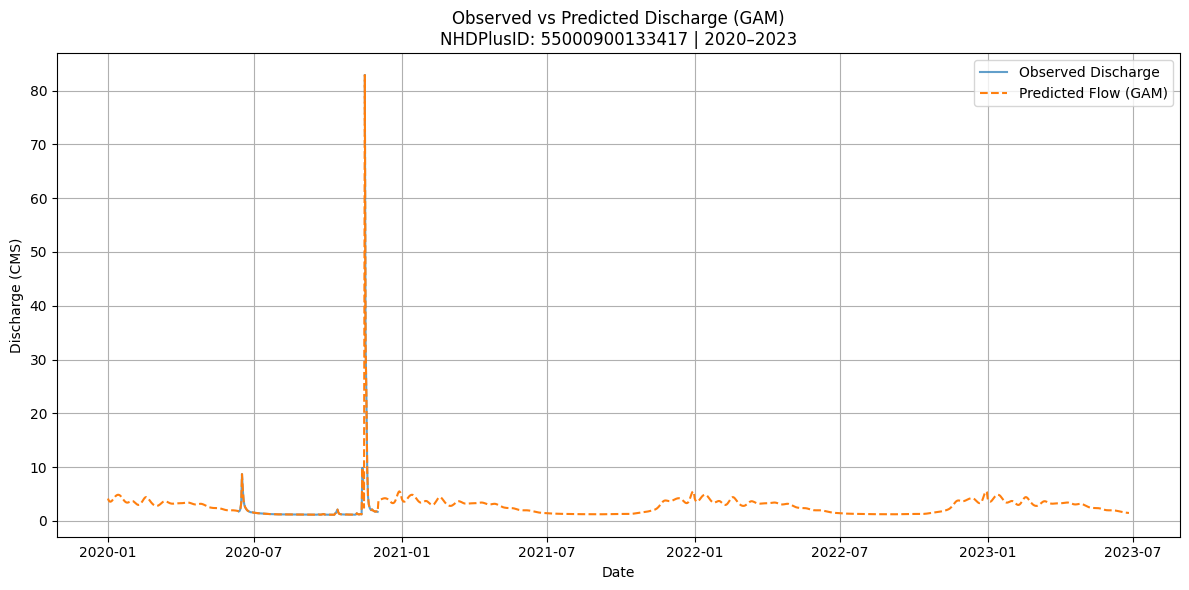

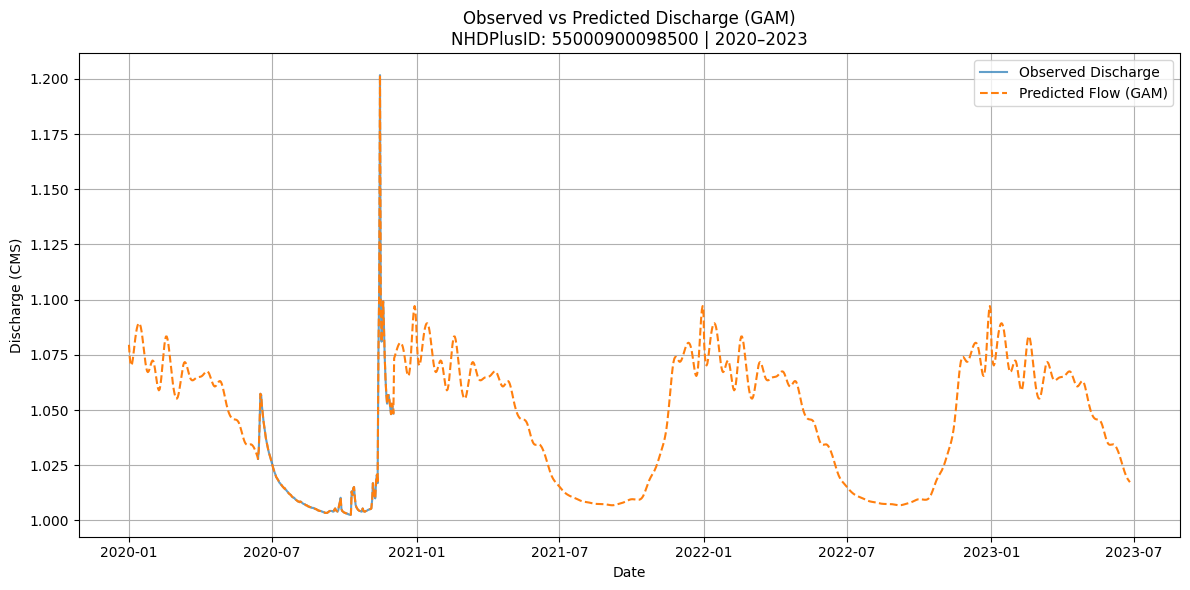

In [31]:
def plot_prediction(df, site_id, target_col="Discharge_CMS", start_year=2020, end_year=2023):
    """
    Plot observed discharge and GAM-predicted flow for a single site
    over a specified year range.
    """

    # Filter data for site and time window
    site_data = df.loc[
        (df["NHDPlusID"] == site_id) &
        (df["Date"].dt.year.between(start_year, end_year))
    ]

    # Create plot
    plt.figure(figsize=(12, 6))

    plt.plot(
        site_data["Date"],
        np.exp(site_data[target_col]),
        label="Observed Discharge",
        alpha=0.7
    )

    plt.plot(
        site_data["Date"],
        np.exp(site_data["combined_prediction"]),
        label="Predicted Flow (GAM)",
        linestyle="--"
    )

    # Formatting
    plt.xlabel("Date")
    plt.ylabel("Discharge (CMS)")
    plt.title(
        f"Observed vs Predicted Discharge (GAM)\n"
        f"NHDPlusID: {site_id} | {start_year}–{end_year}"
    )
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example plots
plot_prediction(predictions_df_gam, "55000900133417")
plot_prediction(predictions_df_gam, "55000900098500")
